In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [2]:
df = pd.read_csv("expense_dataset.csv")
df.head()

,Category,Expense
0,Entertainment,Sport tickets
1,Food,Curd
2,Housing,Rent
3,Food,Pizza
4,Travel,Gasoline


In [3]:
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df

,Category,Expense,category_id
0,Entertainment,Sport tickets,0
1,Food,Curd,1
2,Housing,Rent,2
3,Food,Pizza,1
4,Travel,Gasoline,3
...,...,...,...
914,Savings,Vacation,4
915,Food,Gourmet or luxury food purchases,1
916,Housing,Homeowners association special assessments,2
917,Housing,Window treatments,2


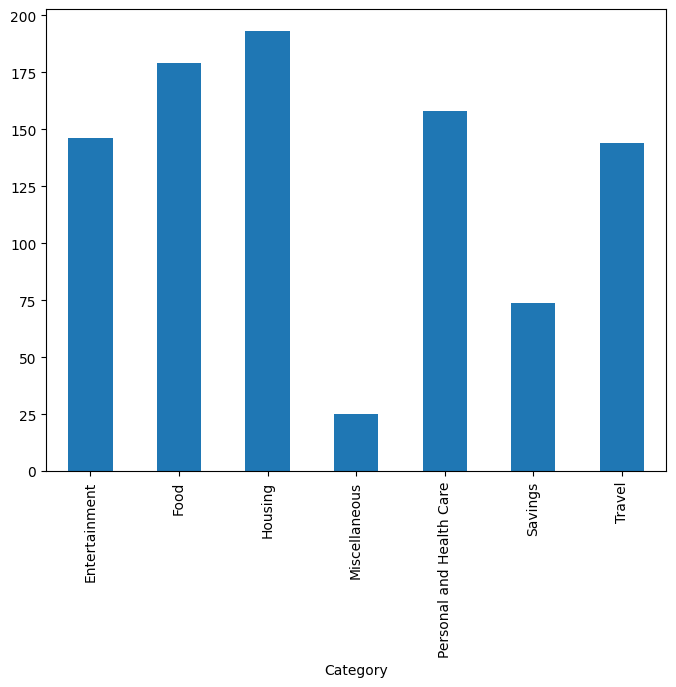

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Expense.count().plot.bar(ylim=0)
plt.show()

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Expense).toarray()
labels = df.category_id
features.shape

(919, 112)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['Expense'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression().fit(X_train_tfidf, y_train)

In [7]:
print(clf.predict(count_vect.transform(["Mc aloo tikki burger"])))

['Food']


In [8]:
print(clf.predict(count_vect.transform(["Dish Washer"])))

['Housing']


In [9]:
print(clf.predict(count_vect.transform(["Movie tickets"])))

['Entertainment']


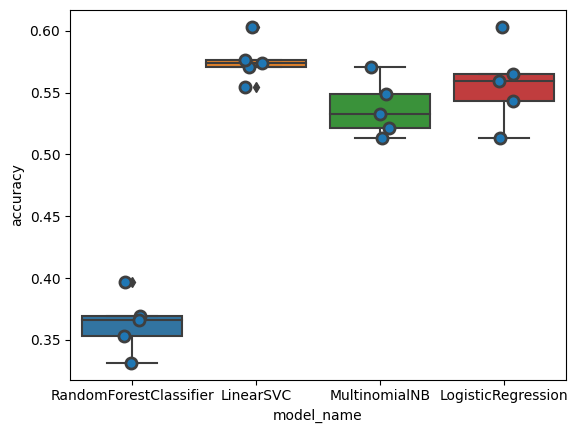

In [10]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [11]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.575624
LogisticRegression        0.557080
MultinomialNB             0.537515
RandomForestClassifier    0.363441
Name: accuracy, dtype: float64

In [12]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

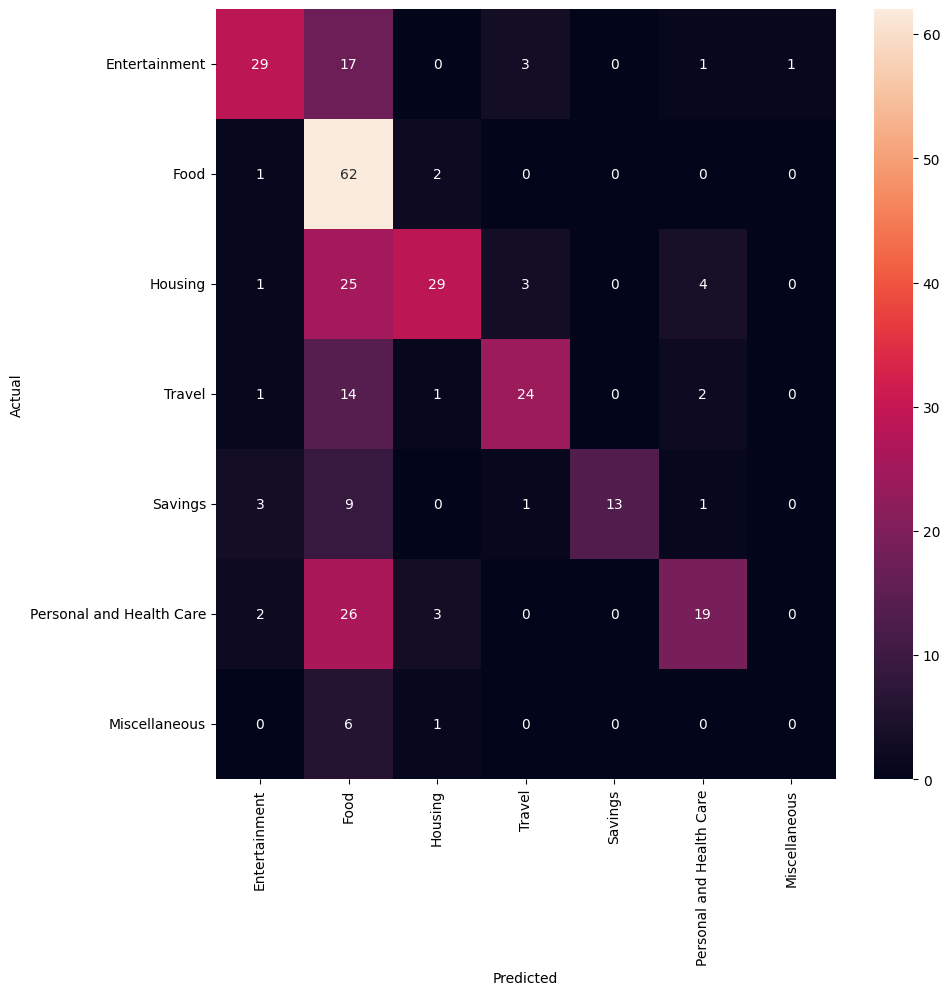

In [13]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
#what all were predicted wrong
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 'Expense']])
      print('')

'Entertainment' predicted as 'Food' : 17 examples.


,Category,Expense
231,Entertainment,Magic or illusionist shows
800,Entertainment,PS5
799,Entertainment,Amazon prime
792,Entertainment,Amazon prime
476,Entertainment,Hobbies
679,Entertainment,Carnivals
731,Entertainment,Book readings or author signings
812,Entertainment,Video game purchases
702,Entertainment,Charity auctions or gala dinners
910,Entertainment,Gambling



'Housing' predicted as 'Food' : 25 examples.


,Category,Expense
298,Housing,Tablesw
408,Housing,Key duplication or replacement
382,Housing,Wallpaper
609,Housing,Electricity Bill
724,Housing,Plumbing fixtures like sinks
358,Housing,moving truck
582,Housing,Sofa
834,Housing,Dishwashers
909,Housing,Bedsheet
805,Housing,Utensils



'Travel' predicted as 'Food' : 14 examples.


,Category,Expense
306,Travel,Luggage bag
31,Travel,Hot air balloon ride over scenic landscapes
580,Travel,Fine dining restaurant meals
843,Travel,Front-row seats to a Broadway musical
493,Travel,Noise-canceling headphones
101,Travel,Fine dining restaurant meals
422,Travel,Deluxe hotel accommodation
162,Travel,Petrol
451,Travel,Taxi Fare
222,Travel,Artisanal food souvenirs



'Personal and Health Care' predicted as 'Food' : 26 examples.


,Category,Expense
631,Personal and Health Care,Acupuncture Session
145,Personal and Health Care,Pediatric vaccinations or immunizations
478,Personal and Health Care,Therapist Session
447,Personal and Health Care,Shampoo
175,Personal and Health Care,Birth control methods and contraceptives
667,Personal and Health Care,Shampoo
200,Personal and Health Care,Makeup and cosmetics
337,Personal and Health Care,Rehabilitation or recovery programs like for s...
196,Personal and Health Care,Dietary supplements or protein powders
721,Personal and Health Care,Vitamins and supplements


In [18]:
model = LinearSVC()

In [20]:
model.fit(X_train,y_train)

LinearSVC()

In [21]:
model.score(X_test,y_test)

0.5789473684210527

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['Expense'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [25]:
print(clf.predict(count_vect.transform(['Pizza'])))

['Food']


In [26]:
print(clf.predict(count_vect.transform(['Dosa'])))

['Food']


In [28]:
print(clf.predict(count_vect.transform(['Hairspray'])))

['Personal and Health Care']


In [29]:
print(clf.predict(count_vect.transform(['Petrol'])))

['Travel']


In [30]:
print(clf.predict(count_vect.transform(['Electricity bill'])))

['Housing']


In [31]:
print(clf.predict(count_vect.transform(['Restaurant'])))

['Food']


In [32]:
print(clf.predict(count_vect.transform(['Bus fare'])))

['Travel']


In [33]:
print(clf.predict(count_vect.transform(['Train ticket'])))

['Travel']


In [34]:
print(clf.predict(count_vect.transform(['Mutual funds'])))

['Savings']


In [36]:
#may come under entertainment and travel
print(clf.predict(count_vect.transform(['Concert tickets'])))

['Miscellaneous']


In [37]:
print(clf.predict(count_vect.transform(['Gas bill'])))

['Housing']


In [38]:
print(clf.predict(count_vect.transform(['Diesel'])))

['Travel']


In [39]:
print(clf.predict(count_vect.transform(['Refrigerator repairs'])))

['Housing']


In [40]:
print(clf.predict(count_vect.transform(['Oats'])))

['Food']


In [41]:
print(clf.predict(count_vect.transform(['Tea'])))

['Food']


In [42]:
print(clf.predict(count_vect.transform(['Butter'])))

['Food']


In [43]:
print(clf.predict(count_vect.transform(['Dolo 650 medicine'])))

['Personal and Health Care']


In [44]:
print(clf.predict(count_vect.transform(['Swiggy order'])))

['Food']


In [45]:
print(clf.predict(count_vect.transform(['Hard disk purchase'])))

['Housing']


In [46]:
print(clf.predict(count_vect.transform(['Adani green investment'])))

['Savings']


In [47]:
print(clf.predict(count_vect.transform(['Samsung galaxy m14 mobile purchase'])))

['Housing']


In [48]:
print(clf.predict(count_vect.transform(['fastrack watch purchase'])))

['Personal and Health Care']


In [49]:
print(clf.predict(count_vect.transform(['Electricity bill'])))

['Housing']


In [54]:
print(clf.predict(count_vect.transform(['Badminton'])))

['Food']


In [55]:
print(clf.predict(count_vect.transform(['Skin doctor'])))

['Personal and Health Care']


In [56]:
print(clf.predict(count_vect.transform(['Ointments'])))

['Personal and Health Care']


In [58]:
print(clf.predict(count_vect.transform(['Lotions and creams'])))

['Personal and Health Care']


In [59]:
print(clf.predict(count_vect.transform(['Zomato order'])))

['Food']


In [60]:
print(clf.predict(count_vect.transform(['Tube light purchase'])))

['Housing']


In [61]:
print(clf.predict(count_vect.transform(['Jio fibre bill'])))

['Housing']


In [62]:
print(clf.predict(count_vect.transform(['Airtel bill'])))

['Housing']


In [63]:
print(clf.predict(count_vect.transform(['vada pav'])))

['Food']


In [64]:
print(clf.predict(count_vect.transform(['House lease'])))

['Housing']


In [65]:
print(clf.predict(count_vect.transform(['Zomato shares'])))

['Savings']


In [66]:
print(clf.predict(count_vect.transform(['Netflix subscription'])))

['Entertainment']


In [67]:
print(clf.predict(count_vect.transform(['Paytm stocks'])))

['Savings']
